***Prueba técnica Inventures Matías Dueñas***

Para resolver este problema, se utiliza un modelo de inventario: un modelo de optimización que tiene como objetivo minimizar los costos, satisfaciendo la demanda. En este caso, se plantea de la siguiente manera:

-   Indices:
    - $t$: Tiempo $t = 1,..., T$, los períodos de tiempo

- Variables:
    - $x_{t}$: Flujo entrante en el tiempo $t$
    - $v_{t}$: Volumen en reservorio en el tiempo $t$

- Parámetros:
    - $D_{t}$: Salida de agua del reservorio en tiempo $t$ (Demanda)
    - $C_{t}$: Costo de energía en el tiempo $t$ [USD/kWh]
    - $P$: El coste de energía por agua desplazada $[kWh/m^{3}]$
    - $V_{min}$: Volumen de agua mínimo en el reservorio $[m^{3}]$
    - $V_{max}$: Volumen de agua máximo en el reservorio $[m^{3}]$
    - $V_{0}$: Volumen de agua inicial en el reservorio $[m^{3}]$
    - $X_{max}$: Capacidad máxima de tubería de entrada $[m^{3}/h]$

- Función objetivo: Minimizar el costo total, que considera solo el transporte de agua desde la planta al reservorio

- Restricciones:
    - Existe un flujo de entrada máximo al reservorio
    - El reservorio tiene una capacidad mínima y máxima
    - El reservorio, previo a la operación, tiene un volumen de agua conocido

El modelo, de forma matemática, queda representado de la siguiente manera:

\begin{equation}
\begin{aligned}
\min_{x, v} \quad & P\cdot\sum_{t=1}^{T}C_{t} \cdot x_{t}\\
\textrm{s.t.} \quad & x_{t} \leq X_{max}, \; &t = 1, \ldots, T.\\
                    & V_{min} \leq v_{t} \leq V_{max}, \; &t = 1, \ldots, T.\\
                    & v_{1} = V_{0} + x_{1} - D_{1}\\
                    & v_{t} = v_{t-1} + x_{t} - D_{t}, \; &t = 2, \ldots, T.\\
                    & 0 \leq x_{t}, v_{t}, \; &t = 1, \ldots, T.\\
\end{aligned}
\end{equation}

Para resolver el modelo de optimización presentado previamente, se implementa de forma computacional

Se cargan las librerías a utilizar

- mip: para resolver el problema lineal
- pandas: para trabajar la carga y manipulación de tablas de datos

In [1]:
import mip
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates

Se cargan los parámetros del modelo:

-   El flujo de salida desde el reservorio en el tiempo $t$
-   El costo de energía en el tiempo $t$
-   El costo energético para mover $m^3$ de agua
-   El volumen mínimo, máximo e inicial del reservorio
-   El flujo de entrada máximo al reservorio

In [2]:
#Se cargan los parámetros desde la tabla de datos entregada,
#y se formatean para poder utilizarlos en futuros cálculos
parametros_reservorio = pd.read_csv('PT_reservorio.csv', sep = ',', encoding='latin-1',
                                    header = 0, names = ['fecha', 'salida', 'costo energia'])
parametros_reservorio['fecha'] = pd.to_datetime(parametros_reservorio['fecha'], dayfirst = True)
parametros_reservorio['costo energia'] = parametros_reservorio['costo energia']\
                                            .str.replace(',', '.').astype(float)
T = parametros_reservorio['fecha'].size

costo_agua = 17.8
volumen_minimo = 1e4
volumen_maximo = 1.6e4
volumen_inicial = 1e4
entrada_maxima = 800

Se crea el modelo de optimización y este es resuelto

In [3]:
#Se crea una instancia de un modelo lineal
modelo_reservorio = mip.Model(sense = mip.MINIMIZE)

#Se crean las variables que contiene el modelo
x = [modelo_reservorio.add_var() for i in range(T)]
v = [modelo_reservorio.add_var() for i in range(T)]

#Se define la función objetivo y se añade al modelo
funcion_objetivo = costo_agua * mip.xsum(x[t] * parametros_reservorio['costo energia'][t] for t in range(T))
modelo_reservorio.objective = funcion_objetivo

#Se añaden las restricciones del modelo
for t in range(T):

    modelo_reservorio += x[t] <= entrada_maxima
    modelo_reservorio += v[t] <= volumen_maximo
    modelo_reservorio += v[t] >= volumen_minimo
    
modelo_reservorio += v[0] == volumen_inicial + x[0] - parametros_reservorio['salida'][0]

for t in range(1, T):

    modelo_reservorio += v[t] == v[t-1] + x[t] - parametros_reservorio['salida'][t]

#Se resuelve el problema
modelo_reservorio.optimize()

#Se almacenan los valores numéricos tanto del costo total como del flujo de entrada
#y el volumen del reservorio
costo_total = modelo_reservorio.objective.x
entrada_agua = {parametros_reservorio['fecha'][i]: x[i].x for i in range(T)}
volumen_reservorio = {parametros_reservorio['fecha'][i]: v[i].x for i in range(T)}

print(f'El costo total de la gestión es de {round(costo_total)} CLP')

El costo total de la gestión es de 19569136 CLP


Se crean gráficos que muestren la estrategia de gestión y el volumen de agua en el reservorio, en cada hora de operación

In [4]:
fechas_costo_nulo = parametros_reservorio['fecha'][parametros_reservorio['costo energia'] == 0]

listas_entrada_agua = sorted(entrada_agua.items())
hora, volumen_entrada = zip(*listas_entrada_agua)

fig, ax = plt.subplots()
ax.plot(hora, volumen_entrada, 'b.-')
ax.grid(True)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m-%H:%M'))
fig.autofmt_xdate()

for fecha in fechas_costo_nulo:
    ax.axvline(fecha, color = 'gray', linestyle = 'dashed',
               label = 'Horas con\ncosto nulo', zorder = -1)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Entrada de agua al reservorio por hora')
plt.xlabel('Hora')
plt.ylabel('Volumen ($m^3$)')
plt.show()

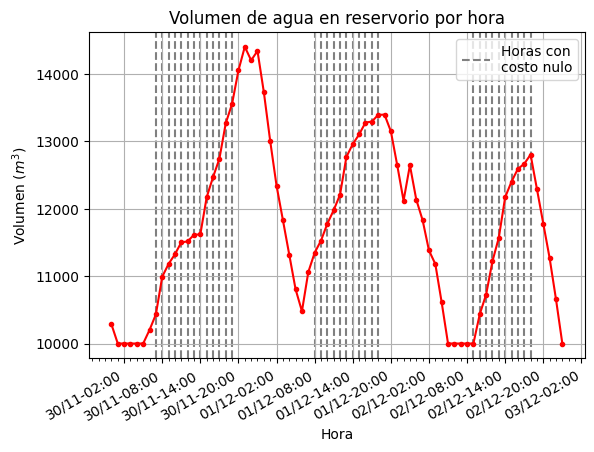

In [5]:
listas_volumen_reservorio = sorted(volumen_reservorio.items())

hora, reservorio = zip(*listas_volumen_reservorio)

fig, ax = plt.subplots()
ax.plot(hora, reservorio, 'r.-')
ax.grid(True)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m-%H:%M'))
fig.autofmt_xdate()

for fecha in fechas_costo_nulo:
    ax.axvline(fecha, color = 'gray', linestyle = 'dashed',
               label = 'Horas con\ncosto nulo', zorder = -1)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 1)

plt.title('Volumen de agua en reservorio por hora')
plt.xlabel('Hora')
plt.ylabel('Volumen ($m^3$)')
plt.show()

La estrategia puede ser descrita de la siguente manera:

- En el período de costo energético nulo, se hace una recarga del reservorio:
    - Se llena el reservorio para asegurar, por lo menos, continuidad operacional.
    - Esta recarga puede ser de mayor volumen, pues no representa un costo total adicional, pero debe respetarse la capacidad máxima del reservorio
- En el período de costo energético eno-nulo, la recarga es mínima:
    - Se llena el reservorio a un nivel de continuidad operacional
    - Esta recarga no tiene holgura en el volumen ingresado, y debe hacerse en los bloques horarios que tengan menor costo energético

Esta estrategia es **óptima**, en el sentido de que es la **de menor costo**. En este caso particular, el monto es de 19.569.136 USD

Aunque es una estrategia óptima, presenta cierta holgura para tomar decisiones: Al observar el gráfico "Entrada de agua al reservorio por hora", en el horario correspondiente al 02/12-09:00 (horario de costo energético nulo), se puede notar que la recarga es de 513 $m^3$. Si esta aumenta a 800 $m^3$, el costo total NO aumenta, solo variará el volumen total en el reservorio.

Dentro de los supuestos de este modelo, se encuentran:

-   El proceso de entrada y salida de agua del reservorio es instantáneo. Esto implica que el flujo neto entre entrada y salida es inmediatamente agregado/disminuido del volumen actual del reservorio.
-   La entrada y salida de agua puede hacerse de forma precisa (toman valores continuos). Esto asume que se puede controlar el flujo como se requiera.
-   Las demandas de agua son conocidas previamente. Esto disminuye las variables del problema ya que se cuenta con más información

Como oportunidades de mejora, se encuentran:

- El modelo solo incluye los costos de energía relacionados a mover el agua desde la planta desalinizadora hasta el reservorio. Un posible paso futuro es considerar los costos de la planta desalinizadora: si son de magnitud mayor a los costos de energía, pueden alterar los horarios de entrada de agua.
- Relajando el supuesto de que el proceso de entrada y salida de agua es instantáneo, se puede modelar de manera distinta el proceso (si así corresponde). Si el proceso de entrada y salida es distinto, se puede subdividir los módulos horarios para tener en cuenta este hecho.